In [1]:
import torch
import torch.nn as nn
import torchvision
from torchmetrics import PeakSignalNoiseRatio

import numpy as np
import datetime, random
import csv, os, argparse, time
import matplotlib.pyplot as plt

from models import CondEnergyModel, EnergyModel, UNet, ConvAE, Resneten, autoencoders

from utils import UNet_Energy_log, Self_Energy_log, Custom_Dataset, SGLD_, clip_grad
from utils import gaussian_noise, calculate_norm, to_numpy, SampleBuffer, get_dataloaders


In [2]:
IMG_SIZE = 32
Batch_size = 128

cuda_device = 0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')

PSNR = PeakSignalNoiseRatio().to(device)

In [3]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(32),
    # torchvision.transforms.RandomCrop(32, padding=4),
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))
    ])

dir_data = '/hdd1/dataset/'

dl_train, dl_test = get_dataloaders(dir_data, "CIFAR10", IMG_SIZE, 
                                        Batch_size, train_size = 2000,
                                        transform=transforms_train,
                                        use_subset = True, use_label=4,
                                        parallel=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
ae = autoencoders()
ae = ae.to(device)
criterion = nn.MSELoss()
optim_ae = torch.optim.Adam(ae.parameters(), lr=0.0001, betas=(0.5, 0.999))

sigmas_np = np.linspace(0.05, 0.5, Batch_size)
sigmas = torch.Tensor(sigmas_np).view((Batch_size, 1, 1, 1)).to(device)

In [5]:
num_epochs = 200

for epoch in range(num_epochs):
    for data, _ in dl_train:
        
        data = data.to(device)
        noisy_image = data + sigmas * torch.randn_like(data)
        
        optim_ae.zero_grad()
        outputs = ae(noisy_image)
        loss_ae = criterion(outputs, noisy_image)
        loss_ae.backward()
        optim_ae.step()
        
        val_psnr = to_numpy(PSNR(data, outputs))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_ae.item():.4f}, PSNR: {val_psnr:.4f}")

Epoch [1/200], Loss: 0.4599, PSNR: -3.0736
Epoch [2/200], Loss: 0.4266, PSNR: 5.9424
Epoch [3/200], Loss: 0.3845, PSNR: 9.0800
Epoch [4/200], Loss: 0.3775, PSNR: 11.4997
Epoch [5/200], Loss: 0.3592, PSNR: 13.0426
Epoch [6/200], Loss: 0.3506, PSNR: 14.0541
Epoch [7/200], Loss: 0.3400, PSNR: 15.1759
Epoch [8/200], Loss: 0.3377, PSNR: 15.0839
Epoch [9/200], Loss: 0.3307, PSNR: 15.9022
Epoch [10/200], Loss: 0.3400, PSNR: 15.4459
Epoch [11/200], Loss: 0.3286, PSNR: 16.2831
Epoch [12/200], Loss: 0.3304, PSNR: 16.1205
Epoch [13/200], Loss: 0.3247, PSNR: 16.1545
Epoch [14/200], Loss: 0.3305, PSNR: 16.0478
Epoch [15/200], Loss: 0.3288, PSNR: 16.5961
Epoch [16/200], Loss: 0.3273, PSNR: 16.2825
Epoch [17/200], Loss: 0.3290, PSNR: 16.4715
Epoch [18/200], Loss: 0.3408, PSNR: 15.8395
Epoch [19/200], Loss: 0.3251, PSNR: 16.8695
Epoch [20/200], Loss: 0.3218, PSNR: 16.8510
Epoch [21/200], Loss: 0.3244, PSNR: 16.8250
Epoch [22/200], Loss: 0.3184, PSNR: 17.0857
Epoch [23/200], Loss: 0.3198, PSNR: 16.8703

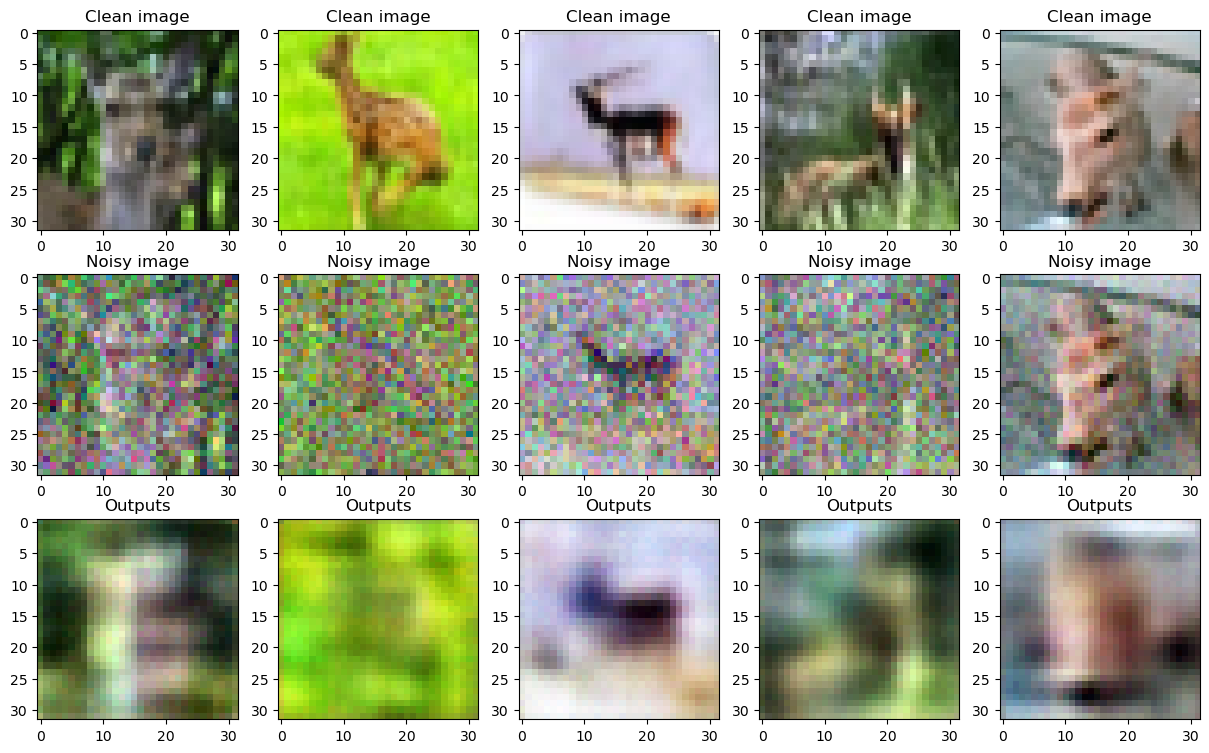

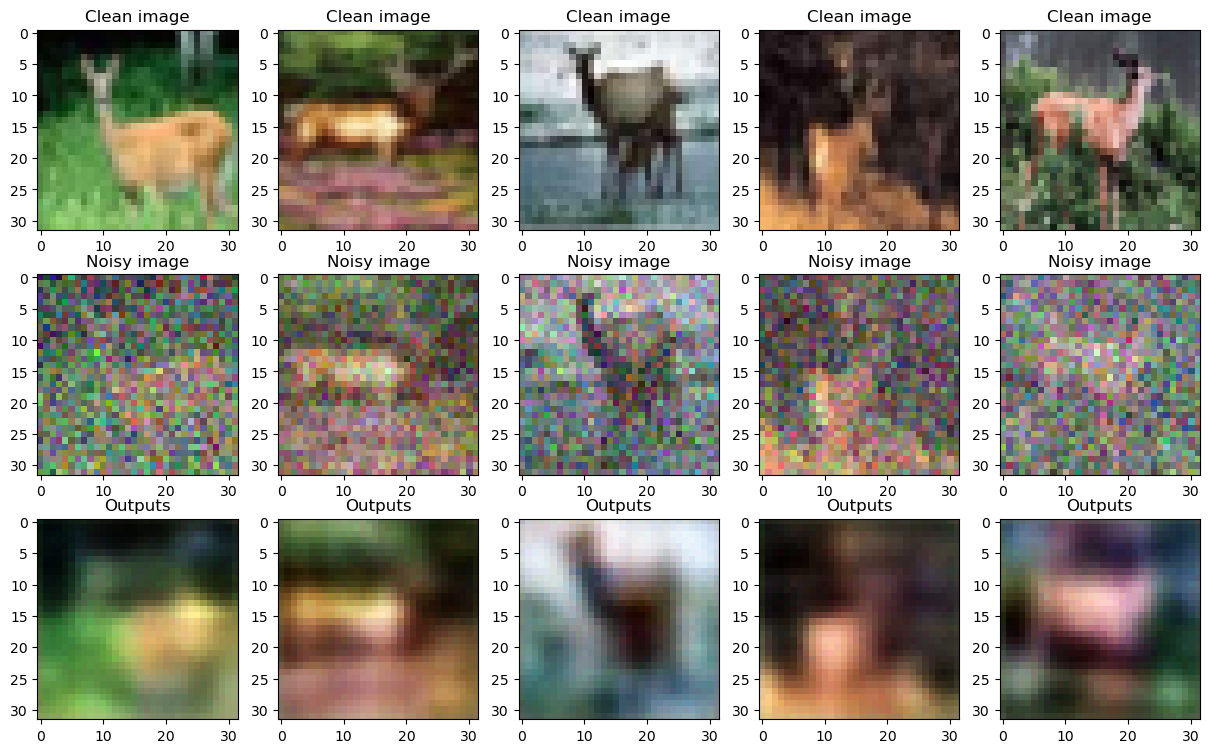

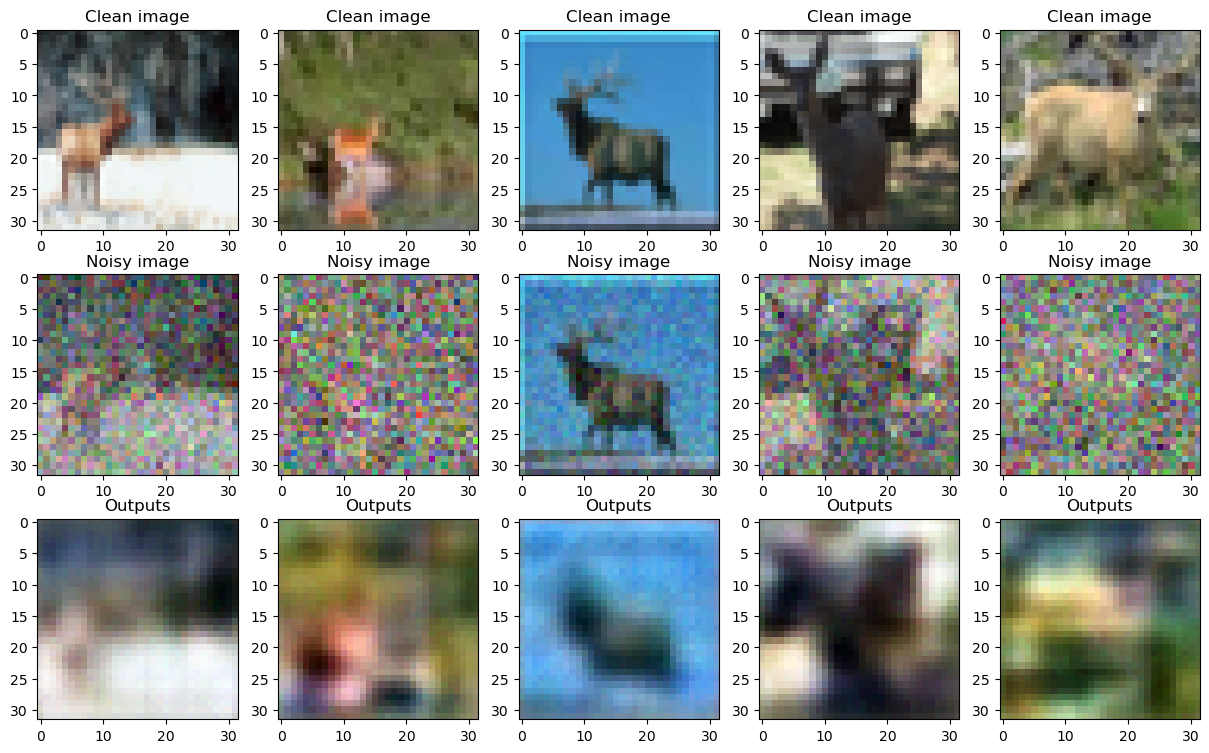

In [6]:
ae.eval()
row = 3
col = 5

for j, (test_img, _) in enumerate(iter(dl_test)):
    
    test_img = test_img.to(device)
    noisy = test_img + sigmas * torch.randn_like(test_img)
    out_img = ae(noisy)
    
    fig, ax = plt.subplots(row, col, figsize = (3*col, 3*row))
    for k in range(col):
        rand = random.randrange(Batch_size)
        ax[0][k].set_title("Clean image")
        ax[0][k].imshow(torchvision.utils.make_grid(test_img[rand].detach().cpu(), normalize=True).permute(1,2,0))
        ax[1][k].set_title("Noisy image")
        ax[1][k].imshow(torchvision.utils.make_grid(noisy[rand].detach().cpu(), normalize=True).permute(1,2,0))
        ax[2][k].set_title("Outputs")
        ax[2][k].imshow(torchvision.utils.make_grid(out_img[rand].detach().cpu(), normalize=True).permute(1,2,0))